In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from pathlib import Path
from collections import defaultdict

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams["axes.grid"] = False
mpl.rcParams["figure.figsize"] = (8,6)

In [4]:
df_path = Path(os.getcwd()) / "StockHistoricalPrices.csv"

In [5]:
df = pd.read_csv(df_path, parse_dates=[0], infer_datetime_format=True)

In [6]:
df.head(5)

,Date,Open,High,Low,Close,Volume
0,1988-05-27,1966.7,1970.8,1944.4,1956.4,10378493.0
1,1988-05-31,1959.4,2034.5,1959.4,2031.1,21163843.0
2,1988-06-01,2031.1,2076.3,2021.3,2064.0,34987714.0
3,1988-06-02,2064.0,2073.3,2030.9,2052.5,23401834.0
4,1988-06-03,2052.5,2080.7,2040.0,2071.3,19643347.0


In [7]:
def add_original_features(df, df_new):
    """
    This function is used to convert the features so that past parameters are present in a row. Then, 
    we will create a model to predict the closing price on a day using the past parameters.
    """
    df_new["date"] = df["Date"]
    df_new["open"] = df["Open"]
    df_new["open_1"] = df["Open"].shift(1)
    df_new["volume_1"] = df["Volume"].shift(1)
    df_new["high_1"] = df["High"].shift(1)
    df_new["low_1"] = df["Low"].shift(1)
    df_new["close_1"] = df["Close"].shift(1)
    df_new["close"] = df["Close"]

In [8]:
def add_avg_price(df, df_new):
    df_new["avg_price_5"] = df["Close"].rolling(5).mean().shift(1)
    df_new["avg_price_30"] = df["Close"].rolling(21).mean().shift(1)
    df_new["avg_price_365"] = df["Close"].rolling(252).mean().shift(1)
    df_new["avg_price_5_30"] = df_new["avg_price_5"]/df_new["avg_price_30"]
    df_new["avg_price_5_365"] = df_new["avg_price_5"]/df_new["avg_price_365"]
    df_new["avg_price_30_365"] = df_new["avg_price_30"]/df_new["avg_price_365"]

In [9]:
def add_avg_volume(df, df_new):
    df_new["avg_volume_5"] = df["Volume"].rolling(5).mean().shift(1)
    df_new["avg_volume_30"] = df["Volume"].rolling(21).mean().shift(1)
    df_new["avg_volume_365"] = df["Volume"].rolling(252).mean().shift(1)
    df_new["avg_volume_5_30"] = df_new["avg_volume_5"]/df_new["avg_volume_30"]
    df_new["avg_volume_5_365"] = df_new["avg_volume_5"]/df_new["avg_volume_365"]
    df_new["avg_volume_30_365"] = df_new["avg_volume_30"]/df_new["avg_volume_365"]

In [10]:
def add_std_price(df, df_new):
    df_new["std_price_5"] = df["Close"].rolling(5).std().shift(1)
    df_new["std_price_30"] = df["Close"].rolling(21).std().shift(1)
    df_new["std_price_365"] = df["Close"].rolling(252).std().shift(1)
    df_new["std_price_5_30"] = df_new["std_price_5"]/df_new["std_price_30"]
    df_new["std_price_5_365"] = df_new["std_price_5"]/df_new["std_price_365"]
    df_new["std_price_30_365"] = df_new["std_price_30"]/df_new["std_price_365"]

In [11]:
def add_std_volume(df, df_new):
    df_new["std_volume_5"] = df["Volume"].rolling(5).std().shift(1)
    df_new["std_volume_30"] = df["Volume"].rolling(21).std().shift(1)
    df_new["std_volume_365"] = df["Volume"].rolling(252).std().shift(1)
    df_new["std_volume_5_30"] = df_new["std_volume_5"]/df_new["std_volume_30"]
    df_new["std_volume_5_365"] = df_new["std_volume_5"]/df_new["std_volume_365"]
    df_new["std_volume_30_365"] = df_new["std_volume_30"]/df_new["std_volume_365"]

In [12]:
def add_return_features(df, df_new):
    df_new["return_1"] = ((df["Close"] - df["Close"].shift(1))/df["Close"].shift(1)).shift(1)
    df_new["return_5"] = ((df["Close"] - df["Close"].shift(5))/df["Close"].shift(5)).shift(1)
    df_new["return_30"] = ((df["Close"] - df["Close"].shift(21))/df["Close"].shift(21)).shift(1)
    df_new["return_365"] = ((df["Close"] - df["Close"].shift(252))/df["Close"].shift(252)).shift(1)
    df_new["return_avg_5"] = df_new["return_1"].rolling(5).mean().shift(1)
    df_new["return_avg_30"] = df_new["return_30"].rolling(21).mean().shift(1)
    df_new["return_avg_365"] = df_new["return_365"].rolling(252).mean().shift(1)

In [13]:
def generate_features(df):
    """
    This function combines all the functions previously created and creates the final dataframe.
    """
    df_new = pd.DataFrame()
    add_original_features(df, df_new)
    add_avg_price(df, df_new)
    add_avg_volume(df, df_new)
    add_std_price(df, df_new)
    add_std_volume(df, df_new)
    add_return_features(df, df_new)
    df_new = df_new.dropna(axis = 0)  ## Droppping all the rows containing na values
    return df_new

In [14]:
df_new = generate_features(df)

In [15]:
## Matching the length of df_new to df as df has more number of entries 
df_trunc = df.copy()   ## But before taking a backup
df_trunc = df_trunc.loc[df_new.index, :]

## Implementing Linear Regression from scratch

Cost function for linear regression

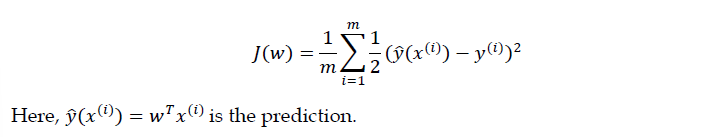

Formula for updating weights for linear regression algorithm. It is derived using the partial derivative of the cost function.

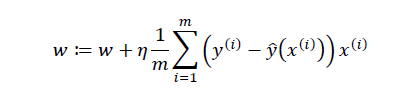

In [99]:
# The weights here includes the bias term...therefore, we will have to include a row of ones
# in the X_train/X_val/X_test matrices

def compute_preds(weights, X_train):
    return np.sum(weights*X_train, axis = 1)

In [93]:
def weights_update(weights, X_train, y_train, learning_rate):
    m = X_train.shape[0]
    delta = (1/m) * (np.dot(X_train.T, y_train - compute_preds(weights, X_train)))
    weights += learning_rate * delta
    return weights

In [94]:
def cost_fun(X_train, y_train, weights):
    m = X_train.shape[0]
    return (1/2*m) * np.sum((compute_preds(weights, X_train) - y_train)**2, axis = 0)

In [115]:
def lin_reg(X_train, y_train, n_iters, learning_rate):
    weights = np.zeros(X_train.shape[1] + 1)
    X_train_ = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    for iter_ in np.arange(n_iters):
        weights = weights_update(weights, X_train_, y_train, learning_rate)
        cost = cost_fun(X_train_, y_train, weights)
    return weights

In [116]:
def  preds(weights, X):
    X_ = np.c_[np.ones((X.shape[0], 1)), X]
    return compute_preds(weights, X_)

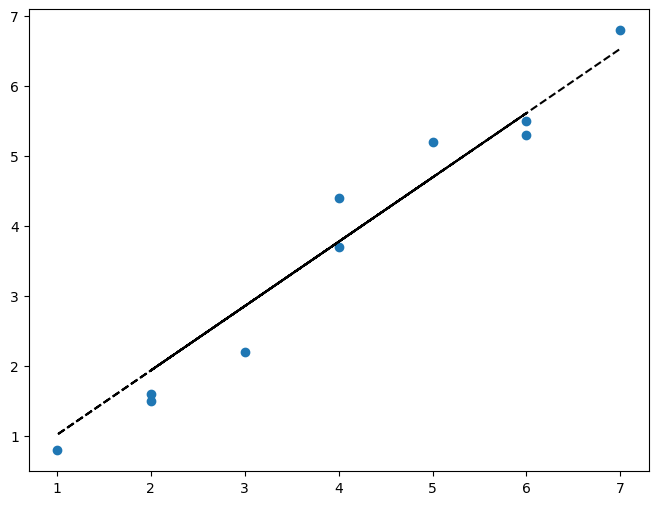

In [128]:
## Checking the linear regression function using a dummy dataset

X_train = np.array([[6], [2], [3], [4], [1],  [5], [2], [6], [4], [7]])
y_train = np.array([5.5, 1.6, 2.2, 3.7, 0.8, 5.2, 1.5, 5.3, 4.4, 6.8])

weights = lin_reg(X_train, y_train, 100, 0.01)

plt.scatter(X_train, y_train)
plt.plot(X_train, preds(weights, X_train), color = "black", linestyle = "dashed")

The above implementation of linear regression algorithm is for practice only. It also helps us to understand the basics of the linear regression model.

## Implementing Decision Tree Regression algorithm from scratch